In [1]:
import os
import pandas as pd
from config.paths import PICKLE_PATHS  # 这是你的路径变量

# 拼接 pickle 文件完整路径
pickle_file = os.path.join(PICKLE_PATHS, "df_with_signal.pkl")

# 读取 DataFrame
df = pd.read_pickle(pickle_file)

# 检查 df 是否包含 signal
print(df[['file_path', 'bearing_type', 'fault_type', 'signal']].head())

# 生成 signal_length 列（如果还没生成）
if 'signal_length' not in df.columns:
    df['signal_length'] = df['signal'].apply(len)

print("信号长度统计：")
print(df['signal_length'].describe())


                                           file_path bearing_type fault_type  \
0  E:/python_file/TransBearingDiag/src/data/sourc...           DE      滚动体故障   
1  E:/python_file/TransBearingDiag/src/data/sourc...           DE      滚动体故障   
2  E:/python_file/TransBearingDiag/src/data/sourc...           DE      滚动体故障   
3  E:/python_file/TransBearingDiag/src/data/sourc...           DE      滚动体故障   
4  E:/python_file/TransBearingDiag/src/data/sourc...           DE      滚动体故障   

                                              signal  
0  [0.19612209317762153, -0.010495391852318566, -...  
1  [0.16097982148905385, -0.11710912062671461, -0...  
2  [-0.101050582052191, -0.13028890540548438, 0.1...  
3  [-0.16744701037262077, -0.15006645149038525, 0...  
4  [0.11470197259011841, -0.19165068210050032, -0...  
信号长度统计：
count       161.00000
mean     131072.52795
std       56553.62104
min       63788.00000
25%       96000.00000
50%       96000.00000
75%      192000.00000
max      384000.00000
Name:

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.fft import fft
import pywt  # 小波变换


# 时域特征
def extract_time_features(signal):
    features = {}
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['max'] = np.max(signal)
    features['min'] = np.min(signal)
    features['rms'] = np.sqrt(np.mean(signal ** 2))
    features['kurtosis'] = kurtosis(signal)
    features['skew'] = skew(signal)
    return features

# 频域特征
def extract_freq_features(signal, sampling_freq):
    n = len(signal)
    yf = fft(signal)
    yf = np.abs(yf[:n // 2])

    features = {}
    features['freq_mean'] = np.mean(yf)
    features['freq_std'] = np.std(yf)
    features['freq_max'] = np.max(yf)
    features['freq_rms'] = np.sqrt(np.mean(yf ** 2))
    return features

# 小波能量特征
def extract_wavelet_features(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = {}
    for i, c in enumerate(coeffs):
        features[f'wavelet_energy_L{i}'] = np.sum(np.square(c)) / len(c)
    return features

# 遍历 DataFrame 提取所有特征
feature_list = []
for idx, row in df.iterrows():
    sig = row['signal']
    sf = row['sampling_freq']  # 采样频率
    fr = row.get('rotor_freq', 1)  # 旋转频率
    Nd = row.get('num_balls', 8)   # 滚动体数量
    d = row.get('ball_diameter', 0.02)  # 滚动体直径（m）
    D = row.get('pitch_diameter', 0.1)  # 滚动体节圆直径（m）

    # 时域特征
    time_feats = extract_time_features(sig)
    # 频域特征
    freq_feats = extract_freq_features(sig, sf)
    # 小波能量特征
    wavelet_feats = extract_wavelet_features(sig)

    bpfo = fr * Nd / 2 * (1 - d / D)   # 外圈故障特征频率
    bpfi = fr * Nd / 2 * (1 + d / D)   # 内圈故障特征频率
    bsf  = fr * D / d * (1 - (d/D)**2) # 滚动体故障特征频率

    bearing_freq_feats = {
        'BPFO': bpfo,
        'BPFI': bpfi,
        'BSF': bsf
    }

    # 合并所有特征
    combined_feats = {**time_feats, **freq_feats, **wavelet_feats, **bearing_freq_feats}
    combined_feats['file_path'] = row['file_path']
    combined_feats['bearing_type'] = row['bearing_type']
    combined_feats['fault_type'] = row['fault_type']

    feature_list.append(combined_feats)

features_df = pd.DataFrame(feature_list)

# 选择数值列
numeric_df = features_df.select_dtypes(include=[np.number])
# 计算相关系数矩阵
corr_matrix = numeric_df.corr().abs()
# 选取上三角矩阵
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# 找出相关性大于 0.95 的列
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("高相关特征（将被删除）:", to_drop)
features_df_reduced = features_df.drop(columns=to_drop)

print("去冗余后的特征维度:", features_df_reduced.shape)
features_df


高相关特征（将被删除）: ['min', 'rms', 'freq_std', 'freq_rms', 'wavelet_energy_L4']
去冗余后的特征维度: (161, 17)


,mean,std,max,min,rms,kurtosis,skew,freq_mean,freq_std,freq_max,...,wavelet_energy_L1,wavelet_energy_L2,wavelet_energy_L3,wavelet_energy_L4,BPFO,BPFI,BSF,file_path,bearing_type,fault_type
0,1.438012e-04,0.137790,0.579469,-0.619627,0.137790,-0.041165,-0.006781,15.335321,39.843455,1212.973813,...,0.010323,0.004932,0.027162,0.021432,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
1,-7.311728e-05,0.138850,0.635778,-0.663541,0.138850,-0.028954,0.007698,14.540171,40.489531,1125.273831,...,0.006885,0.003737,0.027520,0.022479,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
2,-5.491240e-05,0.147506,0.600019,-0.559443,0.147506,-0.150649,0.033860,13.048417,43.800818,2907.968057,...,0.006830,0.005033,0.029715,0.026147,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
3,-4.247564e-05,0.154108,0.667307,-0.724762,0.154108,-0.098736,0.018634,17.015091,44.613934,1861.412603,...,0.008701,0.010818,0.033624,0.026424,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
4,-5.653457e-05,0.147515,2.273465,-1.968204,0.147515,17.806158,0.274311,21.816299,40.163169,1792.298910,...,0.024938,0.008855,0.033510,0.020466,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,3.396454e-04,0.590897,6.630612,-6.128103,0.590897,17.034949,-0.239598,56.097549,252.768026,11753.118440,...,2.504801,1.297110,0.022007,0.000221,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,外圈故障
157,-8.738402e-20,0.072687,0.298696,-0.299196,0.072687,-0.235757,-0.035411,7.461641,35.116228,6920.350380,...,0.006527,0.024408,0.002274,0.000074,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,Normal,正常
158,-1.802738e-04,0.065250,0.251543,-0.320480,0.065251,-0.073555,-0.169537,9.073581,39.403284,6329.798465,...,0.005355,0.011503,0.002682,0.000128,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,Normal,正常
159,-8.675589e-05,0.063086,0.346975,-0.339161,0.063086,-0.078895,-0.168253,8.809818,38.087554,6338.065087,...,0.005722,0.009438,0.003430,0.000172,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,Normal,正常


In [3]:
import os
from config.paths import PICKLE_PATHS
# 保存去冗余后的特征
features_pickle_file = os.path.join(PICKLE_PATHS, "features_df.pkl")
os.makedirs(PICKLE_PATHS, exist_ok=True)
features_df.to_pickle(features_pickle_file)

In [4]:
# 加载已保存的特征 DataFrame
import os
import pandas as pd
from config.paths import PICKLE_PATHS

# 拼接 pickle 文件路径
pickle_file = os.path.join(PICKLE_PATHS, "features_df.pkl")

# 加载 features_df
features_df = pd.read_pickle(pickle_file)

# 显示前几行并查看所有列
pd.set_option('display.max_columns', None)  # 显示所有列
features_df

,mean,std,max,min,rms,kurtosis,skew,freq_mean,freq_std,freq_max,freq_rms,wavelet_energy_L0,wavelet_energy_L1,wavelet_energy_L2,wavelet_energy_L3,wavelet_energy_L4,BPFO,BPFI,BSF,file_path,bearing_type,fault_type
0,1.438012e-04,0.137790,0.579469,-0.619627,0.137790,-0.041165,-0.006781,15.335321,39.843455,1212.973813,42.692774,0.003531,0.010323,0.004932,0.027162,0.021432,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
1,-7.311728e-05,0.138850,0.635778,-0.663541,0.138850,-0.028954,0.007698,14.540171,40.489531,1125.273831,43.021142,0.004191,0.006885,0.003737,0.027520,0.022479,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
2,-5.491240e-05,0.147506,0.600019,-0.559443,0.147506,-0.150649,0.033860,13.048417,43.800818,2907.968057,45.703095,0.003361,0.006830,0.005033,0.029715,0.026147,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
3,-4.247564e-05,0.154108,0.667307,-0.724762,0.154108,-0.098736,0.018634,17.015091,44.613934,1861.412603,47.748471,0.003852,0.008701,0.010818,0.033624,0.026424,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
4,-5.653457e-05,0.147515,2.273465,-1.968204,0.147515,17.806158,0.274311,21.816299,40.163169,1792.298910,45.705920,0.009369,0.024938,0.008855,0.033510,0.020466,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,滚动体故障
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,3.396454e-04,0.590897,6.630612,-6.128103,0.590897,17.034949,-0.239598,56.097549,252.768026,11753.118440,258.918153,0.396449,2.504801,1.297110,0.022007,0.000221,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,DE,外圈故障
157,-8.738402e-20,0.072687,0.298696,-0.299196,0.072687,-0.235757,-0.035411,7.461641,35.116228,6920.350380,35.900216,0.019506,0.006527,0.024408,0.002274,0.000074,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,Normal,正常
158,-1.802738e-04,0.065250,0.251543,-0.320480,0.065251,-0.073555,-0.169537,9.073581,39.403284,6329.798465,40.434498,0.028003,0.005355,0.011503,0.002682,0.000128,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,Normal,正常
159,-8.675589e-05,0.063086,0.346975,-0.339161,0.063086,-0.078895,-0.168253,8.809818,38.087554,6338.065087,39.093154,0.023990,0.005722,0.009438,0.003430,0.000172,3.2,4.8,4.8,E:/python_file/TransBearingDiag/src/data/sourc...,Normal,正常


In [5]:
# 查看特征列名和行列信息
features_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean               161 non-null    float64
 1   std                161 non-null    float64
 2   max                161 non-null    float64
 3   min                161 non-null    float64
 4   rms                161 non-null    float64
 5   kurtosis           161 non-null    float64
 6   skew               161 non-null    float64
 7   freq_mean          161 non-null    float64
 8   freq_std           161 non-null    float64
 9   freq_max           161 non-null    float64
 10  freq_rms           161 non-null    float64
 11  wavelet_energy_L0  161 non-null    float64
 12  wavelet_energy_L1  161 non-null    float64
 13  wavelet_energy_L2  161 non-null    float64
 14  wavelet_energy_L3  161 non-null    float64
 15  wavelet_energy_L4  161 non-null    float64
 16  BPFO               161 non

In [6]:
# 自动检测 DataFrame 中的分类列
categorical_columns = features_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("分类特征分布统计：\n")
for col in categorical_columns:
    print(f"列 '{col}' 的分布情况：")
    display(features_df[col].value_counts())
    print("\n")


分类特征分布统计：

列 'file_path' 的分布情况：


file_path
E:/python_file/TransBearingDiag/src/data/source/raw\12kHz_DE_data\B007_0.mat               1
E:/python_file/TransBearingDiag/src/data/source/raw\12kHz_DE_data\B007_1.mat               1
E:/python_file/TransBearingDiag/src/data/source/raw\12kHz_DE_data\B007_2.mat               1
E:/python_file/TransBearingDiag/src/data/source/raw\12kHz_DE_data\B007_3.mat               1
E:/python_file/TransBearingDiag/src/data/source/raw\12kHz_DE_data\B014_0.mat               1
                                                                                          ..
E:/python_file/TransBearingDiag/src/data/source/raw\48kHz_DE_data\OR021@6_3.mat            1
E:/python_file/TransBearingDiag/src/data/source/raw\48kHz_Normal_data\N_0.mat              1
E:/python_file/TransBearingDiag/src/data/source/raw\48kHz_Normal_data\N_1_(1772rpm).mat    1
E:/python_file/TransBearingDiag/src/data/source/raw\48kHz_Normal_data\N_2_(1750rpm).mat    1
E:/python_file/TransBearingDiag/src/data/source/raw\48kHz_No



列 'bearing_type' 的分布情况：


bearing_type
DE        112
FE         45
Normal      4
Name: count, dtype: int64



列 'fault_type' 的分布情况：


fault_type
外圈故障     77
滚动体故障    40
内圈故障     40
正常        4
Name: count, dtype: int64

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 识别连续特征（数值型）
numeric_cols = features_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("连续特征列：", numeric_cols)

# 描述性统计
print("\n连续特征描述性统计：")
display(features_df[numeric_cols].describe())


连续特征列： ['mean', 'std', 'max', 'min', 'rms', 'kurtosis', 'skew', 'freq_mean', 'freq_std', 'freq_max', 'freq_rms', 'wavelet_energy_L0', 'wavelet_energy_L1', 'wavelet_energy_L2', 'wavelet_energy_L3', 'wavelet_energy_L4', 'BPFO', 'BPFI', 'BSF']

连续特征描述性统计：


,mean,std,max,min,rms,kurtosis,skew,freq_mean,freq_std,freq_max,freq_rms,wavelet_energy_L0,wavelet_energy_L1,wavelet_energy_L2,wavelet_energy_L3,wavelet_energy_L4,BPFO,BPFI,BSF
count,1.610000e+02,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,1.610000e+02,161.0,161.0
mean,9.348302e-05,0.389651,2.765876,-2.638779,0.389659,6.790571,0.032312,37.635007,131.564990,6958.617164,137.749852,0.064566,0.704184,0.348101,0.389488,0.192579,3.200000e+00,4.8,4.8
std,1.853323e-03,0.366345,2.119877,1.968068,0.366341,7.554542,0.132709,41.021421,120.667403,7416.842588,126.461613,0.153844,1.490657,0.962605,1.461052,0.656137,4.454748e-16,0.0,0.0
min,-8.491193e-03,0.063086,0.251543,-10.101141,0.063086,-0.235757,-0.444574,7.461641,26.671605,684.175011,29.059006,0.003361,0.005355,0.002762,0.000886,0.000014,3.200000e+00,4.8,4.8
25%,-7.044002e-05,0.149729,1.502917,-3.322787,0.150478,0.949213,-0.008889,18.424728,47.124575,2292.458127,52.166505,0.008738,0.011155,0.016992,0.009201,0.000198,3.200000e+00,4.8,4.8
50%,1.596700e-17,0.279431,2.186054,-2.044020,0.279431,4.312250,0.038937,26.930563,86.192458,4555.854054,91.678266,0.013131,0.036185,0.060867,0.029012,0.022479,3.200000e+00,4.8,4.8
75%,7.443301e-05,0.526895,3.563824,-1.383584,0.526895,10.552981,0.098542,42.565839,174.914450,8440.412233,180.115385,0.037606,0.501105,0.163361,0.126810,0.110262,3.200000e+00,4.8,4.8
max,1.737436e-02,2.143791,11.664754,-0.299196,2.143792,31.360846,0.427556,267.648164,611.021066,40548.830074,664.229664,0.985615,8.398206,7.997146,9.524397,4.537449,3.200000e+00,4.8,4.8


In [8]:
# 特征标准化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df[numeric_cols])
features_scaled_df = pd.DataFrame(features_scaled, columns=numeric_cols)
print("\n前5行标准化后的特征：")
display(features_scaled_df.head())


前5行标准化后的特征：


,mean,std,max,min,rms,kurtosis,skew,freq_mean,freq_std,freq_max,freq_rms,wavelet_energy_L0,wavelet_energy_L1,wavelet_energy_L2,wavelet_energy_L3,wavelet_energy_L4,BPFO,BPFI,BSF
0,0.027235,-0.689643,-1.034602,1.029157,-0.689673,-0.907143,-0.295490,-0.545307,-0.762490,-0.777092,-0.754013,-0.397973,-0.466925,-0.357613,-0.248764,-0.261654,4.440892e-16,0.0,0.0
1,-0.090173,-0.686741,-1.007957,1.006775,-0.686770,-0.905522,-0.186047,-0.564751,-0.757119,-0.788954,-0.751408,-0.393668,-0.469239,-0.358858,-0.248518,-0.260053,4.440892e-16,0.0,0.0
2,-0.080320,-0.663039,-1.024878,1.059833,-0.663068,-0.921681,0.011704,-0.601230,-0.729592,-0.547846,-0.730134,-0.399080,-0.469276,-0.357508,-0.247011,-0.254446,4.440892e-16,0.0,0.0
3,-0.073588,-0.644963,-0.993037,0.975570,-0.644992,-0.914788,-0.103389,-0.504231,-0.722833,-0.689392,-0.713910,-0.395878,-0.468017,-0.351479,-0.244327,-0.254022,4.440892e-16,0.0,0.0
4,-0.081198,-0.663014,-0.233008,0.341791,-0.663044,1.462691,1.829217,-0.386824,-0.759832,-0.698739,-0.730112,-0.359909,-0.457090,-0.353524,-0.244405,-0.263130,4.440892e-16,0.0,0.0


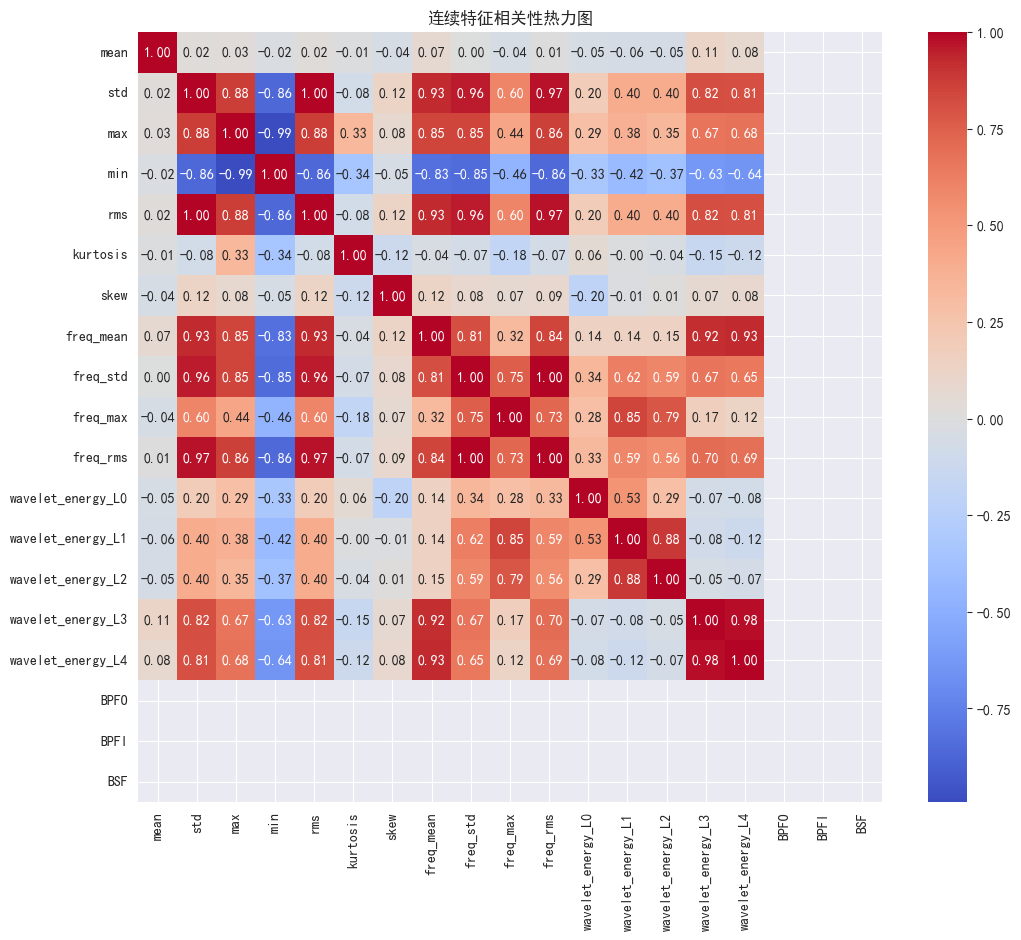

In [9]:
# 特征相关性分析
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

corr_matrix = features_df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("连续特征相关性热力图")
plt.show()


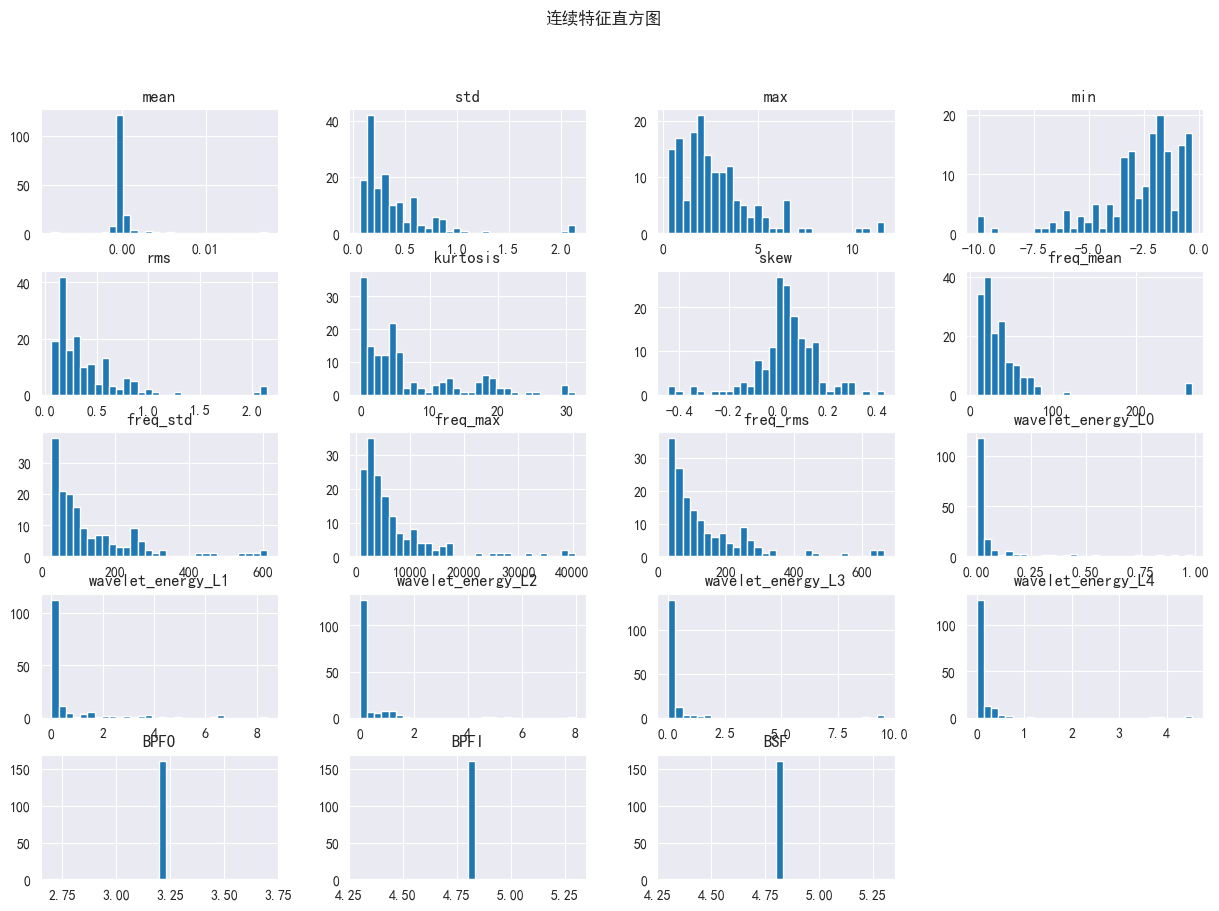

In [10]:
# 连续特征分布可视化
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

features_df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("连续特征直方图")
plt.show()


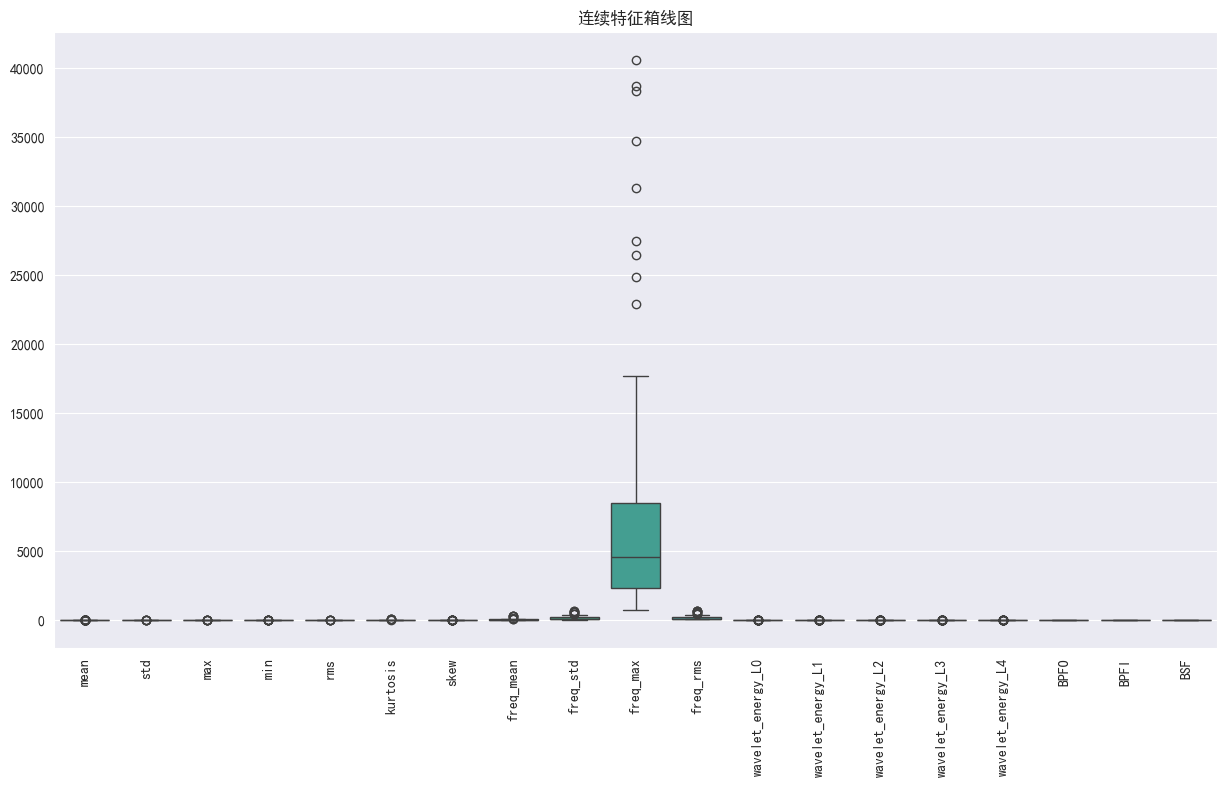

In [11]:
# 连续特征箱线图（查看异常值）
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15, 8))
sns.boxplot(data=features_df[numeric_cols])
plt.title("连续特征箱线图")
plt.xticks(rotation=90)
plt.show()


In [12]:
import os
from sklearn.model_selection import train_test_split
import joblib
from config.paths import PICKLE_PATHS, MODEL_PATHS

# 选择特征列（去掉分类列）
feature_cols = [col for col in features_scaled_df.columns]  # 标准化后的连续特征
X = features_scaled_df[feature_cols].values
y = features_df['fault_type'].values

# 划分训练+验证集和测试集（80% / 20%）
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 从训练+验证集划分出训练集和验证集（75% / 25% -> 最终训练60%，验证20%）
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"训练集样本数: {len(X_train)}, 验证集样本数: {len(X_val)}, 测试集样本数: {len(X_test)}")

# 保存划分结果，后续迁移学习直接加载
split_file = os.path.join(MODEL_PATHS, "train_val_test_split.pkl")
joblib.dump((X_train, X_val, X_test, y_train, y_val, y_test), split_file)



训练集样本数: 96, 验证集样本数: 32, 测试集样本数: 33


['E:/python_file/TransBearingDiag/src/models\\train_val_test_split.pkl']

In [13]:
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import joblib
from config.paths import PICKLE_PATHS

# 加载划分好的数据
split_file = os.path.join(MODEL_PATHS, "train_val_test_split.pkl")
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(split_file)

# 标签编码
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

print("类别映射:", dict(zip(le.classes_, le.transform(le.classes_))))


class BearingDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = BearingDataset(X_train, y_train_enc)
val_dataset = BearingDataset(X_val, y_val_enc)
test_dataset = BearingDataset(X_test, y_test_enc)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"训练 DataLoader 样本数: {len(train_loader.dataset)}")
print(f"验证 DataLoader 样本数: {len(val_loader.dataset)}")
print(f"测试 DataLoader 样本数: {len(test_loader.dataset)}")


类别映射: {'内圈故障': np.int64(0), '外圈故障': np.int64(1), '正常': np.int64(2), '滚动体故障': np.int64(3)}
训练 DataLoader 样本数: 96
验证 DataLoader 样本数: 32
测试 DataLoader 样本数: 33


In [14]:
# for X_batch, y_batch in train_loader:
#     print(X_batch.shape, y_batch.shape)
#     print(y_batch)
#     break


In [15]:
label_mapping = {label: i for i, label in enumerate(np.unique(y))}
joblib.dump(label_mapping, os.path.join(PICKLE_PATHS, "label_mapping.pkl"))


['E:/python_file/TransBearingDiag/src/data/source/processed\\label_mapping.pkl']

In [16]:
scaler_file = os.path.join(PICKLE_PATHS, "scaler.pkl")
joblib.dump(scaler, scaler_file)


['E:/python_file/TransBearingDiag/src/data/source/processed\\scaler.pkl']